In [1]:
%matplotlib inline
%run utils.ipynb

In [2]:
import matplotlib.pyplot as plt
from matplotlib import colors, ticker
# import cartopy.crs as ccrs

import pandas as pd
import numpy as np
import scipy as sp
from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord
import arviz as az
import seaborn as sns

import kinesis as kn
import gapipes as gp

plt.style.use(mystyledict)

In [3]:
%store -r out_full
df = out_full#.loc[out_full['Member_r19']!='other']

In [4]:
print(f"{len(df)} rows, {len(df.columns)} columns")

1389 rows, 142 columns


In [6]:
# slices of data
gdr2 = df.groupby('in_dr2').get_group(True)

In [7]:
df[["in_dr2", "in_leao", "in_meingast", "in_roser"]].fillna(False).groupby(["in_dr2"]).sum()

,in_leao,in_meingast,in_roser
in_dr2,,,
False,7.0,92.0,568.0
True,56.0,146.0,462.0


In [8]:
df[["in_dr2", "in_leao", "in_meingast", "in_roser"]].fillna(False).groupby('in_dr2').get_group(False).groupby('in_meingast').sum()

,in_dr2,in_leao,in_roser
in_meingast,,,
False,0.0,2.0,495.0
True,0.0,5.0,73.0


In [9]:
df[["in_dr2", "in_leao", "in_meingast", "in_roser"]].fillna(False).groupby('in_dr2').get_group(False).groupby('in_roser').sum()

,in_dr2,in_leao,in_meingast
in_roser,,,
False,0.0,1.0,19.0
True,0.0,6.0,73.0


0.4289178378742824


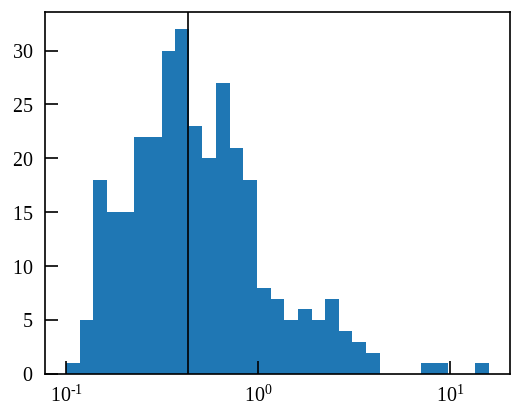

In [13]:
fig, ax = plt.subplots()
ax.hist(df['radial_velocity_error'].dropna(), np.logspace(-1,1.2,32));
median_rv_error = df['radial_velocity_error'].median()
print(median_rv_error)
ax.axvline(median_rv_error, c='k',lw=1);
ax.set_xscale('log');

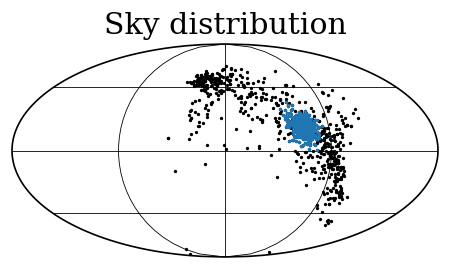

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2.5), subplot_kw=dict(projection=ccrs.Mollweide()))
ax.gridlines(
    crs=ccrs.Geodetic(),
    xlocs=[-180, -90, 0, 90, 180],
    ylocs=[0, 45, 90, -45, -90],
    linewidth=0.5,
    zorder=0,
)
ax.scatter(df["ra"], df["dec"], s=1, c='k', transform=ccrs.Geodetic())
ax.scatter(gdr2["ra"], gdr2["dec"], s=1, transform=ccrs.Geodetic())
ax.set_global()
ax.set_title("Sky distribution")
fig.tight_layout()
fig.savefig('../plots/hyades-sky.pdf')

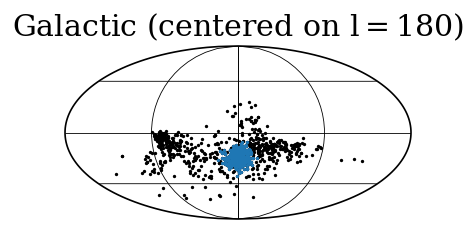

In [8]:
fig, ax = plt.subplots(1, 1,  figsize=(4, 2.5),subplot_kw=dict(projection=ccrs.Mollweide(central_longitude=180)))
ax.gridlines(
    crs=ccrs.Geodetic(),
    xlocs=[-180, -90, 0, 90, 180],
    ylocs=[0, 45, 90, -45, -90],
    linewidth=0.5,
    zorder=0,
)
ax.scatter(df["l"], df["b"], s=1, c='k', transform=ccrs.Geodetic())
ax.scatter(gdr2["l"], gdr2["b"], s=1, transform=ccrs.Geodetic())
ax.set_global()
ax.set_title("Galactic (centered on $l=180$)")
fig.tight_layout()
fig.savefig('../plots/hyades-galactic-distribution.pdf')

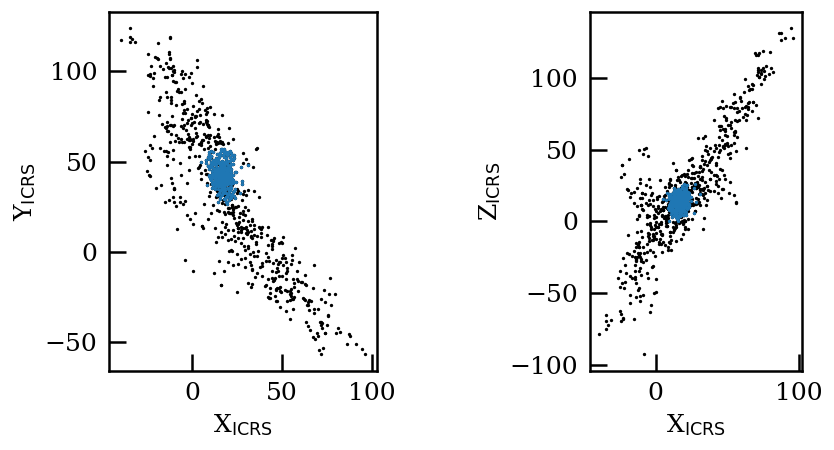

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for cax in ax:
    cax.set_aspect("equal")
for dset, color in zip([df, gdr2], ["k", None]):
    cartx, cartv = dset.g.icrs.cartesian, dset.g.icrs.velocity
    ax[0].scatter(cartx.x, cartx.y, s=1, c=color)
    ax[1].scatter(cartx.x, cartx.z, s=1, c=color)
for cax in ax:
    cax.set_xlabel("$X_\mathrm{ICRS}$")
ax[0].set_ylabel("$Y_\mathrm{ICRS}$")
ax[1].set_ylabel("$Z_\mathrm{ICRS}$")
fig.tight_layout()
fig.savefig('../plots/hyades-xyz-icrs.pdf')

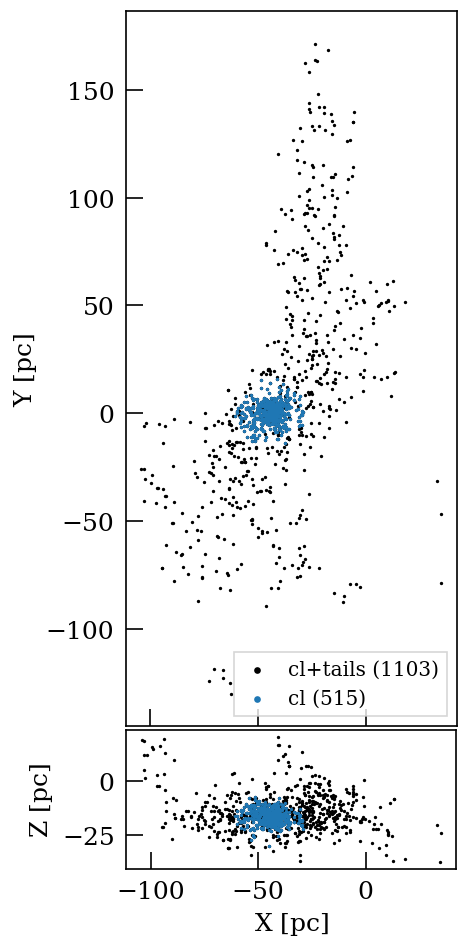

In [72]:
xlims = (-115, 42)
ylims = (-145, 186)
zlims = (-50, 30)

totheight = ((zlims[1]-zlims[0]) + (ylims[1]-ylims[0]))/(xlims[1]-xlims[0])
height_ratio = (ylims[1]-ylims[0])/(zlims[1]-zlims[0])
fig_xsize = 3
fig_ysize = totheight * fig_xsize


fig, ax = plt.subplots(2, 1, figsize=(fig_xsize+1., fig_ysize),
                       sharex=True, gridspec_kw={'height_ratios':[height_ratio, .8]})
for cax in ax: cax.set_aspect('equal');
labels = ['cl+tails ({})'.format(len(df)), 'cl ({})'.format(len(gdr2))]
for dset, color, label in zip([df, gdr2], ['k', None], labels):
    cartx, cartv = dset.g.galactic.cartesian, dset.g.galactic.velocity
    ax[0].scatter(cartx.x, cartx.y, s=1, c=color, label=label);
    ax[1].scatter(cartx.x, cartx.z, s=1, c=color);
ax[1].set_xlabel('$X$ [pc]')
ax[0].set_ylabel('$Y$ [pc]')
ax[1].set_ylabel('$Z$ [pc]');
ax[0].legend(loc='lower right', fontsize=12, markerscale=3, fancybox=False)
fig.subplots_adjust(left=0.22, bottom=0.08,top=0.99, right=0.98, hspace=0.01)
fig.savefig('../report/plots/hyades-data-dist.pdf')

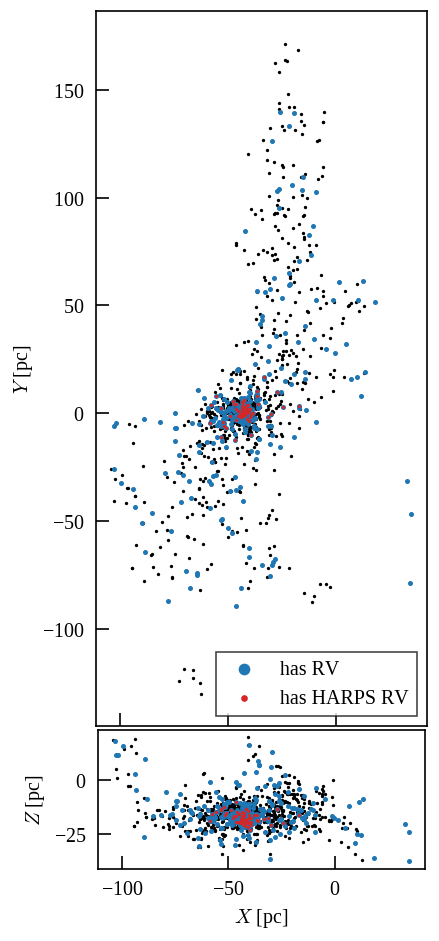

In [13]:
gdr2_rv = df.loc[df['radial_velocity'].notnull()]
harps_rv = df.loc[df['RV_HARPS_leao'].notnull()]
xlims = (-115, 42)
ylims = (-145, 186)
zlims = (-50, 30)

totheight = ((zlims[1]-zlims[0]) + (ylims[1]-ylims[0]))/(xlims[1]-xlims[0])
height_ratio = (ylims[1]-ylims[0])/(zlims[1]-zlims[0])
fig_xsize = 3
fig_ysize = totheight * fig_xsize


fig, ax = plt.subplots(2, 1, figsize=(fig_xsize+1., fig_ysize),
                       sharex=True, gridspec_kw={'height_ratios':[height_ratio, .8]})
for cax in ax: cax.set_aspect('equal');
labels = ['', 'has RV'.format(len(gdr2_rv)), 'has HARPS RV']
for dset, color, label, s in zip([df, gdr2_rv,harps_rv], ['k', None,'tab:red'], labels, [1, 4,1]):
    cartx, cartv = dset.g.galactic.cartesian, dset.g.galactic.velocity
    ax[0].scatter(cartx.x, cartx.y, s=s, c=color, label=label);
    ax[1].scatter(cartx.x, cartx.z, s=s, c=color);
ax[1].set_xlabel('$X$ [pc]')
ax[0].set_ylabel('$Y$ [pc]')
ax[1].set_ylabel('$Z$ [pc]');
ax[0].legend(loc='lower right', fontsize=12, markerscale=3, fancybox=False)
fig.subplots_adjust(left=0.22, bottom=0.08,top=0.99, right=0.98, hspace=0.01)
# fig.savefig('../report/plots/hyades-data-dist-rv.pdf')

In [111]:
df[["radial_velocity", "RV_HARPS_leao", "source_id"]].notnull().groupby(
    ["radial_velocity", "RV_HARPS_leao"]
).agg("count")

source_id
radial_velocity RV_HARPS_leao           
False           False                782
                True                   2
True            False                258
                True                  61

mean delta RV (DR2-HARPS) =  -0.1519
mean delta RV (DR2-HARPS) / error =  -0.6405


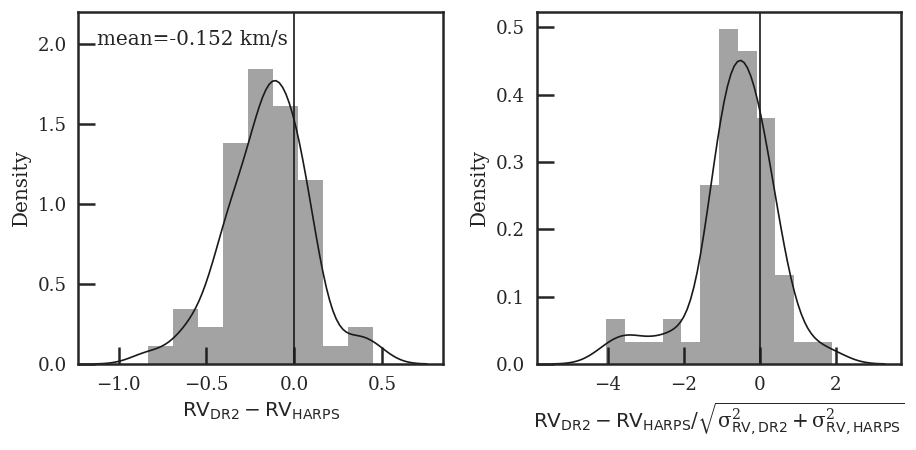

In [111]:
delta_rv = df["radial_velocity"] - df["RV_HARPS_leao"]
delta_rv_sigma = delta_rv / np.hypot(df["radial_velocity_error"], df["eRV_HARPS_leao"])

mean_delta_rv = np.nanmean(delta_rv)
mean_delta_rv_sigma = np.nanmean(delta_rv_sigma)
print(f"mean delta RV (DR2-HARPS) = {mean_delta_rv:-8.4f}")
print(f"mean delta RV (DR2-HARPS) / error = {mean_delta_rv_sigma:-8.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1 = sns.distplot(
    delta_rv[~np.isnan(delta_rv)],
    ax=ax1,
    color="k",
    hist_kws={"lw":0},
    kde_kws={"lw": 1},
)
ax1.axvline(0, c="k", lw=1)
ax1.set_xlabel(r"$\mathrm{RV}_\mathrm{DR2} - \mathrm{RV}_\mathrm{HARPS}$")
ax1.set_ylabel("Density")
ax1.text(
    0.05,
    0.95,
    f"mean={mean_delta_rv:-.3f} km/s",
    ha="left",
    va="top",
    size=12,
    transform=ax1.transAxes,
)
ax1.set_yticks([0, .5, 1, 1.5, 2.])
ax1.set_ylim(0, 2.2)

sns.distplot(
    delta_rv_sigma[~np.isnan(delta_rv_sigma)],
    ax=ax2,
    color="k",
    hist_kws={"lw":0},
    kde_kws={"lw": 1},
)
ax2.axvline(0, c="k", lw=1)
ax2.set_xlabel(
    r"$\mathrm{RV}_\mathrm{DR2} - \mathrm{RV}_\mathrm{HARPS}"
    r"/ \sqrt{\sigma_\mathrm{RV, DR2}^2+\sigma_\mathrm{RV, HARPS}^2}$"
)
ax2.set_ylabel("Density")
fig.tight_layout()
fig.savefig("../plots/compare-gaia-harps-rv.pdf")

/home/soh/.conda/envs/nitro/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


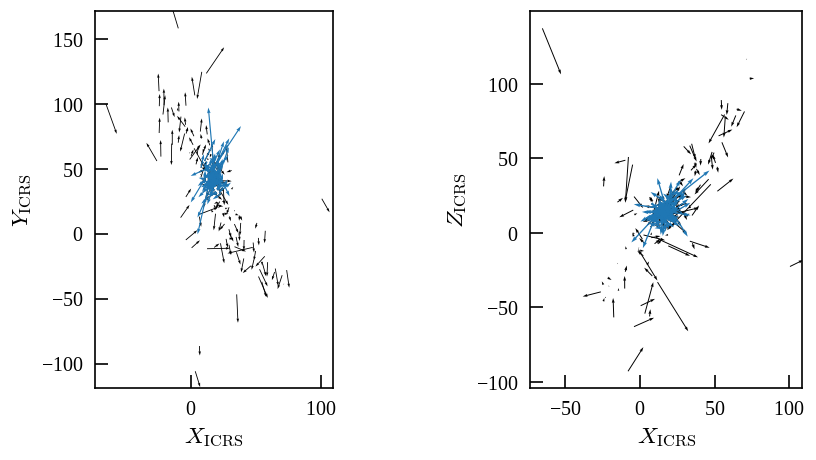

In [7]:
mean_cartv_icrs = [-6.03, 45.56, 5.57]
vx, vy, vz = mean_cartv_icrs

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for cax in ax:
    cax.set_aspect("equal")
for dset, color in zip([df, gdr2], ["k", None]):
    cartx, cartv = dset.g.icrs.cartesian, dset.g.icrs.velocity
    dvx, dvy, dvz = cartv.d_xyz.value - np.array(mean_cartv_icrs)[:,None]
    cond = (np.abs(dvx)<5) & (np.abs(dvy)<5) & (np.abs(dvz)<5)
#     ax[0].scatter(cartx.x, cartx.y, s=1, c=color)
    ax[0].quiver(cartx.x[cond], cartx.y[cond], dvx[cond], dvy[cond], color=color)
    ax[1].quiver(cartx.x[cond], cartx.z[cond], dvx[cond], dvz[cond], color=color)
for cax in ax:
    cax.set_xlabel("$X_\mathrm{ICRS}$")
ax[0].set_ylabel("$Y_\mathrm{ICRS}$")
ax[1].set_ylabel("$Z_\mathrm{ICRS}$")
fig.tight_layout()
# fig.savefig('../plots/hyades-xyz-vector-icrs.pdf')

/home/soh/.conda/envs/matrix/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


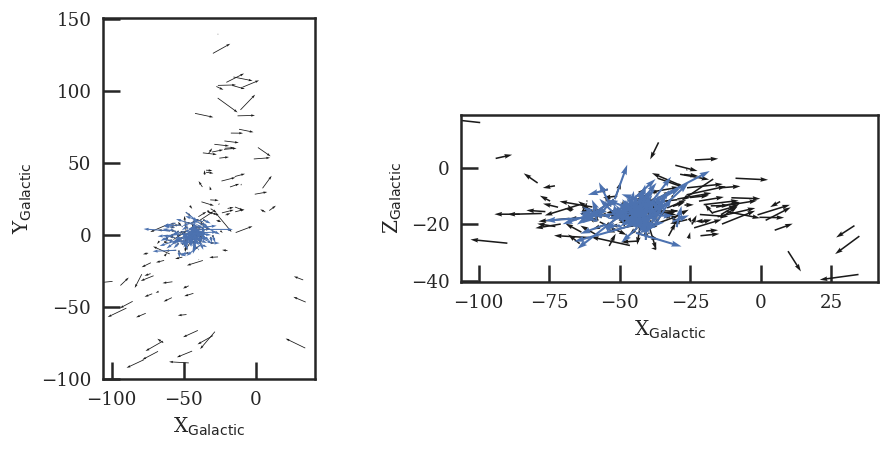

In [113]:
mean_cartv_galactic = [-42.24, -19.00, -1.48]
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for cax in ax:
    cax.set_aspect("equal")
for dset, color in zip([df, gdr2], ["k", None]):
    cartx, cartv = dset.g.galactic.cartesian, dset.g.galactic.velocity
    dvx, dvy, dvz = cartv.d_xyz.value - np.array(mean_cartv_galactic)[:, None]
    cond = (np.abs(dvx) < 3) & (np.abs(dvy) < 3) & (np.abs(dvz) < 3)
    #     ax[0].scatter(cartx.x, cartx.y, s=1, c=color)
    ax[0].quiver(cartx.x[cond], cartx.y[cond], dvx[cond], dvy[cond], color=color)
    ax[1].quiver(cartx.x[cond], cartx.z[cond], dvx[cond], dvz[cond], color=color)
for cax in ax:
    cax.set_xlabel("$X_\mathrm{Galactic}$")
ax[0].set_ylabel("$Y_\mathrm{Galactic}$")
ax[1].set_ylabel("$Z_\mathrm{Galactic}$")
fig.tight_layout()
fig.savefig('../plots/hyades-xyz-vector-galactic.pdf')

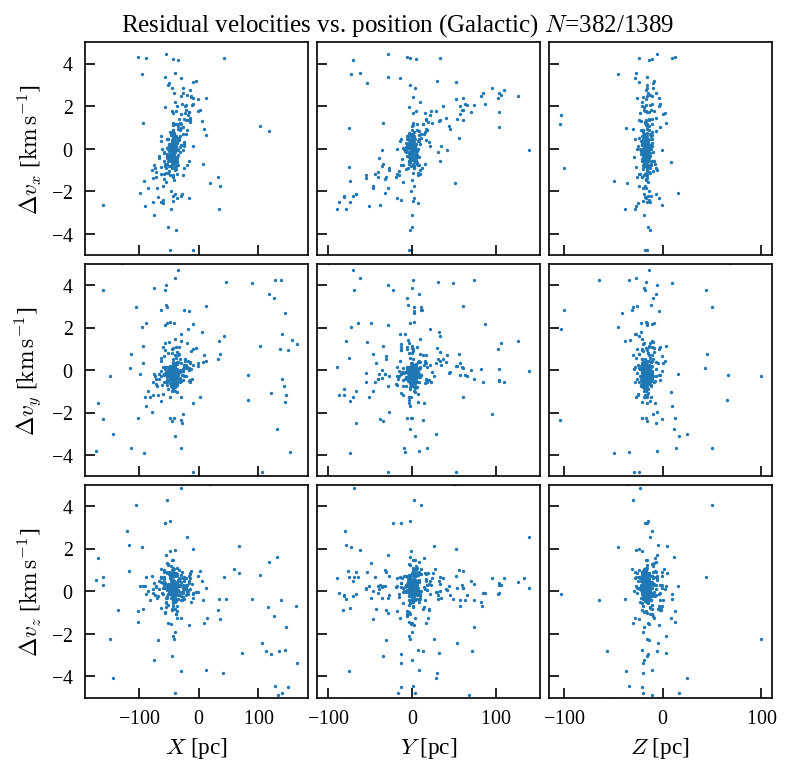

In [8]:
mean_cartv_galactic = [-42.24, -19.00, -1.48]
fig, ax = plt.subplots(
    3, 3, figsize=(6.5, 6.5), sharex="col", sharey="all"
)

dset = df
cartx, cartv = dset.g.galactic.cartesian, dset.g.galactic.velocity
dvx, dvy, dvz = cartv.d_xyz.value - np.array(mean_cartv_galactic)[:, None]

xyz = cartx.xyz.value
dvxyz = [dvx, dvy, dvz]

for icol in range(3):
    for irow in range(3):
        ax[irow, icol].scatter(xyz[icol], dvxyz[irow], s=1)

ax[0, 0].set_ylim(-5, 5)
for cax in ax.ravel():
    cax.set_yticks([-4, -2, 0, 2, 4])
    cax.tick_params(width=1, length=6)
fig.subplots_adjust(wspace=0.04, hspace=0.04, left=0.15, bottom=0.15, top=0.94)
for cax, label in zip(ax[:, 0], ["x", "y", "z"]):
    cax.set_ylabel(
        r"$\Delta v_{0}$".format(label) + r" [$\mathrm{km}\,\mathrm{s}^{-1}$]"
    )
ax[2, 0].set_xlabel("$X$ [pc]")
ax[2, 1].set_xlabel("$Y$ [pc]")
ax[2, 2].set_xlabel("$Z$ [pc]")
fig.suptitle(
    "Residual velocities vs. position (Galactic) $N$={}/{}".format(
        (~np.isnan(dvx)).sum(), len(df)
    ), size=15
)
fig.subplots_adjust(right=0.98, left=0.1, bottom=0.1)
# fig.savefig("../plots/residual-velocity-vs-position-galactic.pdf")

In [143]:
error_summary = pd.DataFrame(
    dict(
        pmra_error_frac=np.abs(df["pmra_error"] / df["pmra"]),
        pmdec_error_frac=np.abs(df["pmdec_error"] / df["pmdec"]),
        parallax_error_frac=np.abs(df["parallax_error"] / df["parallax"]),
    )
).describe()
error_summary

,pmra_error_frac,pmdec_error_frac,parallax_error_frac
count,1103.000000,1103.000000,1103.000000
mean,0.009132,0.009775,0.005404
std,0.083817,0.040876,0.005020
min,0.000166,0.000231,0.000895
25%,0.000953,0.001876,0.002733
50%,0.001560,0.003234,0.003941
75%,0.003233,0.006673,0.006253
max,1.931996,0.910569,0.084348


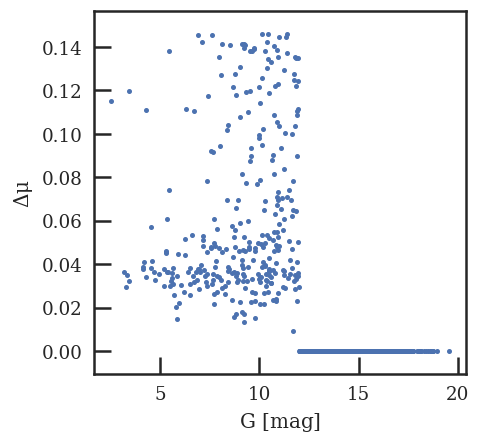

In [133]:

pmdelta = np.hypot( *(df_gfr[['pmra', 'pmdec']].values - df[['pmra', 'pmdec']].values).T)
plt.scatter(df['phot_g_mean_mag'],  pmdelta, s=4);
plt.xlabel('$G$ [mag]')
plt.ylabel(r'$\Delta \mu$');

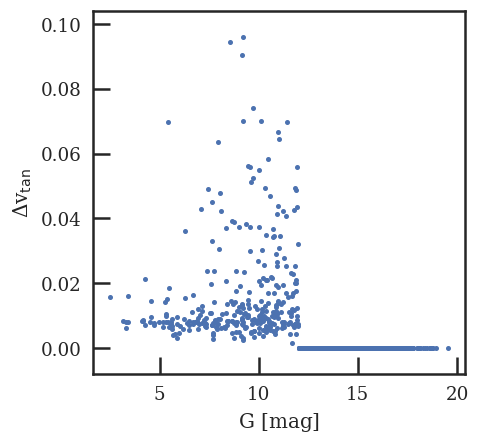

In [137]:
deltav = np.hypot((df_gfr.g.vra-df.g.vra).values, (df_gfr.g.vdec-df.g.vdec).values)
plt.scatter(df['phot_g_mean_mag'],  deltav, s=4);
plt.xlabel('$G$ [mag]')
plt.ylabel(r'$\Delta v_{\mathrm{tan}}$');

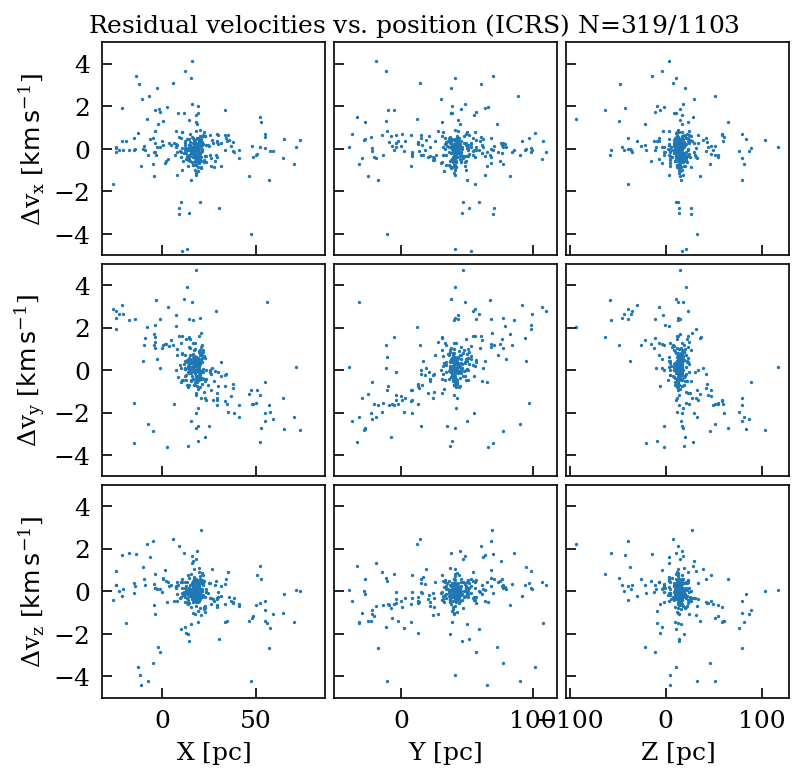

In [8]:
mean_cartv_icrs = [-6.03, 45.56, 5.57]
fig, ax = plt.subplots(
    3, 3, figsize=(6.5, 6.5), sharex="col", sharey="all"
)

dset = df
cartx, cartv = dset.g.icrs.cartesian, dset.g.icrs.velocity
dvx, dvy, dvz = cartv.d_xyz.value - np.array(mean_cartv_icrs)[:, None]

xyz = cartx.xyz.value
dvxyz = [dvx, dvy, dvz]

for icol in range(3):
    for irow in range(3):
        ax[irow, icol].scatter(xyz[icol], dvxyz[irow], s=1)

ax[0, 0].set_ylim(-5, 5)
for cax in ax.ravel():
    cax.set_yticks([-4, -2, 0, 2, 4])
    cax.tick_params(width=1, length=6)
fig.subplots_adjust(wspace=0.04, hspace=0.04, left=0.15, bottom=0.15, top=0.85)
for cax, label in zip(ax[:, 0], ["x", "y", "z"]):
    cax.set_ylabel(r"$\Delta v_{0}$".format(label)+r" [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax[2,0].set_xlabel("$X$ [pc]")
ax[2,1].set_xlabel("$Y$ [pc]")
ax[2,2].set_xlabel("$Z$ [pc]")
fig.suptitle(
    "Residual velocities vs. position (ICRS) $N$={}/{}".format(
        (~np.isnan(dvx)).sum(), len(df)
    ), size=15
)
fig.subplots_adjust(right=0.98, left=0.1, bottom=0.1, top=0.94)
# fig.savefig("../plots/residual-velocity-vs-position-icrs.pdf")

316


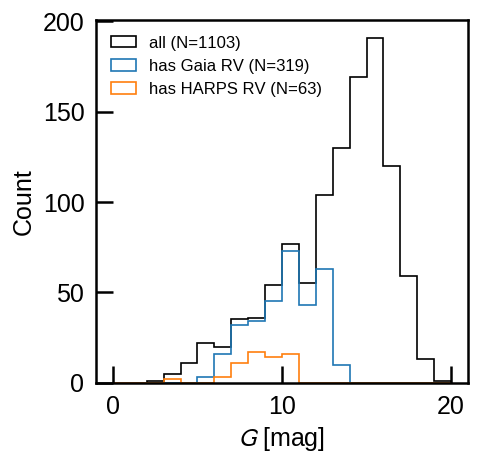

In [239]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel("$G$ [mag]")
n_bright_sources = (df["phot_g_mean_mag"] < 12).sum()
print(n_bright_sources)

ax.hist(
    df["phot_g_mean_mag"],
    bins=np.linspace(0, 20, 21),
    histtype="step",
    color="k",
    label="all (N={})".format(len(df)),
)
ax.hist(
    df.dropna(subset=["radial_velocity"])["phot_g_mean_mag"],
    bins=np.linspace(0, 20, 21),
    histtype="step",
    label="has Gaia RV (N={})".format(df["radial_velocity"].notna().sum()),
)
ax.hist(
    df.dropna(subset=["RV_HARPS_leao"])["phot_g_mean_mag"],
    bins=np.linspace(0, 20, 21),
    histtype="step",
    label="has HARPS RV (N={})".format(df["RV_HARPS_leao"].notna().sum()),
)
ax.legend(loc="upper left", fontsize=10, frameon=False);
ax.set_ylabel('Count');

Text(0, 0.5, '$M_G$ [mag]')

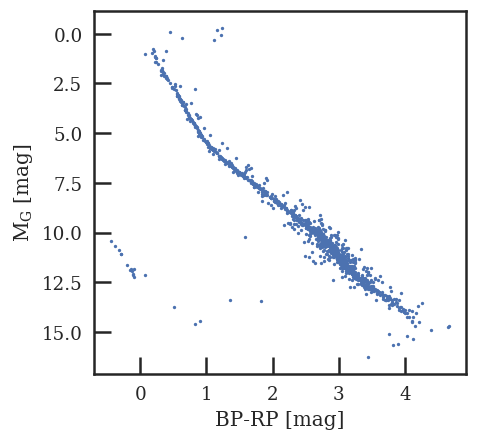

In [97]:
df = out_full.loc[out_full["Member_r19"] != "other"]
fig, ax = plt.subplots()
ax.scatter(
    df["bp_rp"],
    df["phot_g_mean_mag"] + df.g.distmod,
    s=1, c='k'
)


ax.invert_yaxis()
ax.set_xlabel("BP-RP [mag]")
ax.set_ylabel("$M_G$ [mag]");

number of sources in Reino selection: 173 rows


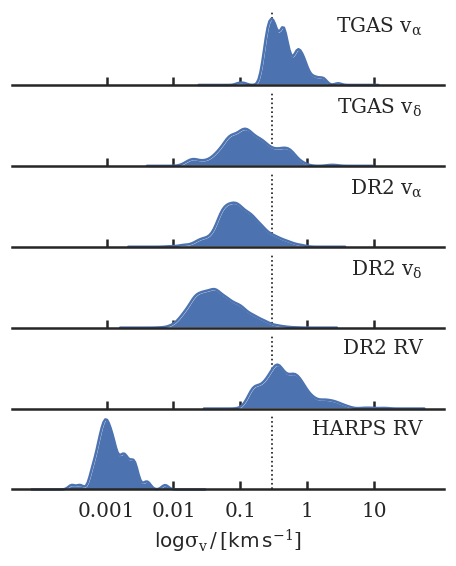

In [96]:
# get tgas data for velocity uncertainty comparison
hy_tgas = pd.read_csv("../data/reino_tgas_full.csv", index_col=0)
print(f"number of sources in Reino selection: {len(hy_tgas)} rows")

tmp = pd.concat(
    [
        hy_tgas.g.vra_error.rename("v").to_frame().assign(label=r"TGAS $v_\alpha$"),
        hy_tgas.g.vdec_error.rename("v").to_frame().assign(label=r"TGAS $v_\delta$"),
        df.g.vra_error.rename("v").to_frame().assign(label=r"DR2 $v_\alpha$"),
        df.g.vdec_error.rename("v").to_frame().assign(label=r"DR2 $v_\delta$"),
        #         df.g.vra_error.rename('v').to_frame().assign(label='HG vra'),
        #         df.g.vdec_error.rename('v').to_frame().assign(label='HG vdec'),
        df["radial_velocity_error"].rename("v").to_frame().assign(label="DR2 RV"),
        df["eRV_HARPS_leao"].rename("v").to_frame().assign(label="HARPS RV"),
    ]
)
tmp["v"] = np.log10(tmp["v"])
tmp.groupby('label').describe()

g = sns.FacetGrid(tmp, row="label", aspect=5, height=0.8)
g.map(sns.kdeplot, "v", clip_on=False, shade=True, alpha=1, lw=1.5, bw=0.2)
g.set_titles("")
g.fig.subplots_adjust(hspace=0.1, top=0.95, right=0.95, left=0.05, bottom=0.12)

g.set(xticklabels=["0.001", "0.01", "0.1", "1", "10"], xticks=[-3, -2, -1, 0, 1])
g.set(yticks=[])
for cax, label in zip(g.fig.axes, g.row_names):
    cax.spines["left"].set_visible(False)
    cax.tick_params(length=5, labelsize=12)
    cax.text(0.95, 0.95, label, ha='right', va='top', transform=cax.transAxes,
             bbox=dict(facecolor='w'), size=12)
    cax.axvline(np.log10(0.3), c='k', lw=1, linestyle=':', zorder=-1);
g.fig.axes[-1].set_xlabel(r'$\log \sigma_v\,/\,[\mathrm{km}\,\mathrm{s}^{-1}$]');
g.fig.savefig("../plots/hyades-velocity-uncertainty-distribution.pdf")

In [ ]:
cl_center_icrs_cart = []